# ECE 311 Lab 2: LSI Systems

In this lab, we will explore Linear Shift-Invariant (LSI) systems and their properties with applications involving toy signals, image filtering, stock data, and even an example of a simple non-linear system. Let's get started!

In [1]:
#import necessary libraries for this lab
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

from skimage.io import imread, imsave

%matplotlib inline

## Getting Started with Convolution

We remember from ECE 210, that convolution describes how any continuous-time input signal is processed by an LTI system. Given an input $x(t)$ and an LTI system's impulse response $h(t)$, the system output $y(t)$ is given by

$$
y(t) = x(t) * h(t).
$$

Recall that convolution for continous signals is defined as

$$
y(t) = \int_{\tau = -\infty}^{\infty}x(\tau)h(t-\tau)d\tau = \int_{\tau=-\infty}^{\infty}x(t-\tau)h(\tau)d\tau.
$$

You have learned in ECE 310 that discrete-time LSI systems also have an impulse response $h[n]$, which is the system response to a unit Kronecker delta $\delta[n]$ input. Thus we can express the system output given an input signal via discrete-time convolution.

$$
y[n] = x[n] * h[n]
$$

$$
y[n] = \sum_{k=-\infty}^{\infty}x[k]h[n-k] = \sum_{k=-\infty}^{\infty}x[n-k]h[k]
$$

It is important to note that every LSI system can be represented by a convolution, every system that can be expressed as a convolution has an impulse response, and any system with an impulse response must be LSI. This means the relationship between LSI systems, convolution, and impulse responses is an "if and only if" relationship; they all imply one another! This is something handy to keep in mind whenever you want to identify and describe an LSI system.

The key function we will use to perform convolutions is the $\textrm{convolve()}$ function in the $\textrm{scipy.signal}$ module. The usage of this function for an example system is as follows:

$$
x[n] = \delta[n]+2\delta[n-2]+3\delta[n-4]
$$

$$
y[n] = x[n]+3x[n-1]
$$

In [2]:
x = np.array([1,0,2,0,3]) #input signal
h = np.array([1,3]) #filter/system's impulse response
y = signal.convolve(x,h) #signal.convolve(in1,in2)

print(y) #verify this result by hand!

[1 3 2 6 3 9]


Note how we extracted the system's impulse response for the system's Linear Constant Coefficient Difference Equation (LCCDE). Our first term takes the present input value and multiplies it by one, and the second term multiplies the most recent input by three. Intuitively, when we flip and shift our filter $h$ for the convolution, we will be applying this system to the input signal at each shift step. The $\textrm{signal.convolve()}$ function assumes the arrays that represent our signals begin at index zero.

## Exercise 1: Implementing LSI Systems

In the below code cell, implement the following LSI systems and plot the system response (using $\textrm{plt.stem()}$) to each of the listed input signals. Comment on the results in the following Markdown cell. Remember to determine the LCCDE for each system to infer its impulse response!

* System A: $y_a[n] = -x[n]+2x[n-1]-x[n-2]$


* System B: $y_b[n] = \frac{1}{4}x[n]+\frac{1}{2}x[n-1]+\frac{1}{4}x[n-2]$



* $x_1[n] = u[n] - u[n-7], 0\leq n\leq 10$


* $x_2[n] = \sin(\frac{\pi}{2}n), 0\leq n\leq 10$

Text(0,0.5,'output')

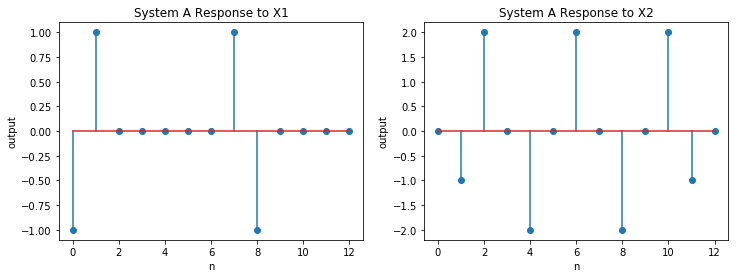

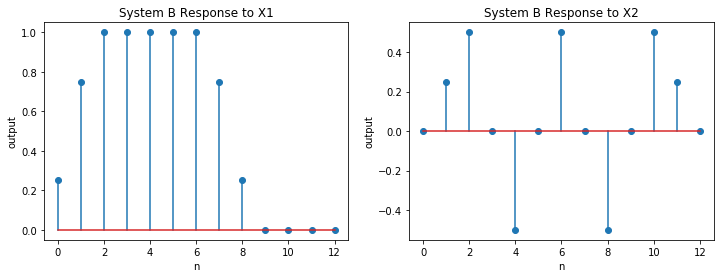

In [3]:
#create input signals here:
#Hint: Use np.sin and np.pi!
x1 = np.array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0])
x2 = np.array([np.sin(np.pi/2*n) for n in range(11)])

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.stem(range(len(x1)), x1)
plt.title('Input Signal X1')
plt.xlabel('n')
plt.ylabel('value')
plt.subplot(122)
plt.stem(range(len(x2)), x2)
plt.title('Input Signal X2')
plt.xlabel('n')
plt.ylabel('value')

#System A
ha = np.array([-1, 2, -1])
plt.figure(figsize=(12,4))

#plot result for x1
y = signal.convolve(x1, ha)
n = range(len(y))
plt.subplot(121)
plt.stem(n, y)
plt.title('System A Response to X1')
plt.xlabel('n')
plt.ylabel('output')

#plot result for x2
y = signal.convolve(x2, ha)
n = range(len(y))
plt.subplot(122)
plt.stem(n, y)
plt.title('System A Response to X2')
plt.xlabel('n')
plt.ylabel('output')

#System B
hb = np.array([0.25, 0.5, 0.25])
plt.figure(figsize=(12,4))

#plot result for x1
y = signal.convolve(x1, hb)
n = range(len(y))
plt.subplot(121)
plt.stem(n, y)
plt.title('System B Response to X1')
plt.xlabel('n')
plt.ylabel('output')

#plot result for x2
y = signal.convolve(x2, hb)
n = range(len(y))
plt.subplot(122)
plt.stem(n, y)
plt.title('System B Response to X2')
plt.xlabel('n')
plt.ylabel('output')

**Comments here:**
(Consider how the different filters affect the flatter and faster moving parts of the input signals. What do you think each filter is doing?)

System A responds to high frequency components of the input signal and attenuates low frequency components.  This causes the spikes in response to the sharp rise and fall of input $X_1$ and the zero response during the steady state part of the input.  **This is like a high-pass filter.**

System B responds to low frequency components while attenuating high frequencies in the input signal.  This causes the slower "ramp" for input $X_1$ while maintaining the steady-state portion.  For input $X_2$, the oscillations remain, but are significantly reduced.  **This is like a low-pass filter.**

## Exercise 2: Bitcoin Pricing Correction

One type of signal could be some non-physical 1D information. An example of this would be stock price or cryptocurrency data. This data is notoriously noisy and can jump around unpredictably.

Remember that the systems we work with can be either causal or non-causal. A causal system only uses present and past information or values to calculate its present values, while a non-causal system can leverage future information. In this excercise, we will compare causal and non-causal versions of a filter to smooth a day's worth of bitcoin pricing data. We have provided 24 hours of prices with pricing updates every minute (1440 points). The date in question is Christmas Eve Day (12/24), 2017.

Text(0,0.5,'Price (USD)')

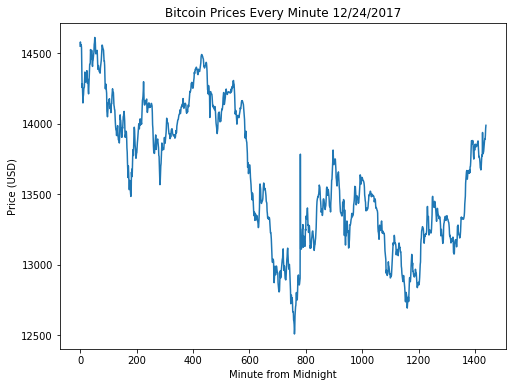

In [4]:
bitcoin_data = np.load('bitcoin-christmas.npy')
n_points = len(bitcoin_data)
plt.figure(figsize = (8,6))
plt.plot(range(n_points),bitcoin_data)
plt.title('Bitcoin Prices Every Minute 12/24/2017')
plt.xlabel('Minute from Midnight')
plt.ylabel('Price (USD)')

Pretty noisy, right? Maybe a lot of last-minute Christmas gifts made the price even more unpredictable!

In this exercise, you will implement two length-51 moving average filters on this Bitcoin price data. The first will be causal and the second will be non-causal. Mathematically, we can represent these systems as follows:

$$
y_1[n] = \frac{1}{51}\sum_{i=0}^{50}x[n - i]
$$

$$
y_2[n] = \frac{1}{51}\sum_{i=-25}^{25}x[n - i]
$$

For this exercise, we will assume zero initial conditions. In other words, all values before time zero are zero. We suggest you use a "for" loop implementation for parts (a) and (b) instead of $\textrm{signal.convolve()}$ to make sure you get the causal versus non-causal versions' time indices consistent. Refer to the below comments and provided code for guidance.

a. Apply the causal filter to the provided bitcoin price data (contained in the ``bitcoin_data`` variable). Plot the original and smoothed data on the same plot.

b. Apply the non-causal filter to the provided bitcoin price data. Plot the original and smoothed data on the same plot. Use a "for" loop to execute this system and guarantee it is non-causal.

c. Plot the error signals for each filter on the same plot. Let the error signal for a system's output be given by

$$
y_e = y - \hat{y},
$$

where $\hat{y}$ is the system output.

d. Comment on the results in the following Markdown cell. Is it better to know a lot of past information or a decent amount of past and future information?

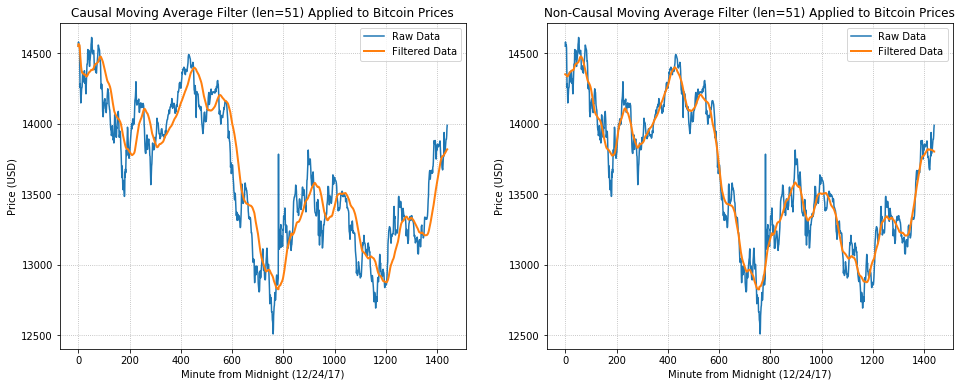

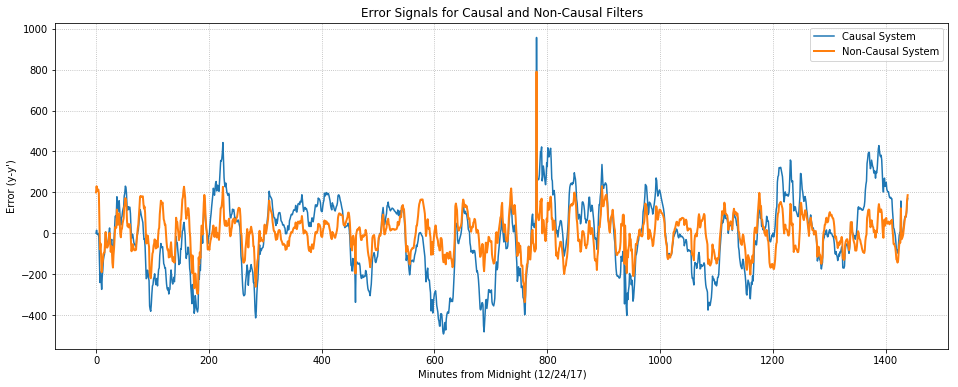

In [5]:
# Code for 2.a here, don't forget to plot original and filtered signals on same plot!
L = 51 # length of our averaging filter
bitcoin_data = bitcoin_data[:-2]  # trim off NaN from end of bitcoin data
L_data = len(bitcoin_data)

plt.figure(figsize=(16,6))

causal_result = []
for n in range(L_data):
    value = 0
    # partial overlap
    if (n < L):
        value += sum(bitcoin_data[:n+1])      # average inputs from beginning to n
        value /= n+1
    # full overlap
    else:
        value += sum(bitcoin_data[n-L:n])     # average inputs from n - L to n
        value /= L
    causal_result.append(value)

plt.subplot(121)
plt.plot(range(len(bitcoin_data)), bitcoin_data, label='Raw Data')
plt.plot(range(len(causal_result)), causal_result, label='Filtered Data', linewidth=2)
plt.title('Causal Moving Average Filter (len=51) Applied to Bitcoin Prices')
plt.xlabel('Minute from Midnight (12/24/17)')
plt.ylabel('Price (USD)')
plt.grid(True, which='both', linestyle=':')
plt.legend()


# Code for 2.b here
noncausal_result = []
for n in range(L_data):
    value = 0
    # partial overlap: entering the signal
    if (n < L/2):
        value += sum(bitcoin_data[:n+L//2])        # average inputs from the beginning to L/2 ahead of n
        value /= (n + L//2)
    # partial overlap: exiting the signal
    elif (n > L_data - L/2):
        value += sum(bitcoin_data[n-L//2:L_data])  # average inputs from L/2 behind n to the end
        value /= (L_data - n + L//2)
    # full overlap
    else:
        value += sum(bitcoin_data[n-L//2:n+L//2])  # average inputs from L/2 behind n to L/2 ahead of n
        value /= L-1
    noncausal_result.append(value)

plt.subplot(122)
plt.plot(range(len(bitcoin_data)), bitcoin_data, label='Raw Data')
plt.plot(range(len(noncausal_result)), noncausal_result, label='Filtered Data', linewidth=2)
plt.title('Non-Causal Moving Average Filter (len=51) Applied to Bitcoin Prices')
plt.xlabel('Minute from Midnight (12/24/17)')
plt.ylabel('Price (USD)')
plt.grid(True, which='both', linestyle=':')
plt.legend()

# Code for 2.c here

plt.figure(figsize=(16,6))
plt.plot(range(len(causal_result)), bitcoin_data - causal_result, label='Causal System')
plt.plot(range(len(noncausal_result)), bitcoin_data - noncausal_result, label='Non-Causal System', linewidth=2)
plt.title('Error Signals for Causal and Non-Causal Filters')
plt.xlabel('Minutes from Midnight (12/24/17)')
plt.ylabel('Error (y-y\')')
plt.grid(True, which='both', linestyle=':')
plt.legend();

**Comments for part 2.d here:**

It is better to know a decent amount of past and future information.  The non-causal system was able to respond very quickly to changes because it could "prepare" for them ahead of time.  The causal system also lags behind the actual data, generally following the shape, just a few points behind.  The error for the non-causal system is therefore much lower.


# Image Convolution

In ECE 310, we typically focus on the implications of filtering in the frequency domain of a 1D signal. Our most common idea of a 1D signal is a piece of audio. In this section, we will experiment with image filtering along both axes of an image and see that we can do more than just filtering with convolution.

## Exercise 3: 1D Image Convolution

Implement a 1D length 21 moving average filter on the ``lena.jpg`` image along its:

a. Rows

b. Columns

c. Rows then columns

d. Columns then rows

Plot each of the resulting images and give them unique titles.

e. Comment on the images from the "rows then columns" and "columns then rows" procedures. Are they the same? Explain your answer, why are they the same or different?

In [6]:
#make filter and load image
image = imread('lena.jpg')
plt.figure(figsize=(10,6))
plt.imshow(image,'gray')
plt.title('Original Image')
L = 21
h = np.ones(L) * 1/21

plt.figure(figsize=(12, 12))
#Code for 3.a along rows (apply filter to each row independently)
image_row = np.zeros(image.shape)
for i in range(image.shape[0]):
    image_row[i,:] = signal.convolve(image[i,:],h,'same')
plt.subplot(221)
plt.imshow(image_row, 'gray')
plt.title('Row Convolution')

#along the columns (3.b)
image_col = np.zeros(image.shape)
for i in range(image.shape[1]):
    image_col[:,i] = signal.convolve(image[:,i],h,'same')
plt.subplot(222)
plt.imshow(image_col, 'gray')
plt.title('Column Convolution')

#rows then columns (3.c)
image_rc = np.zeros(image.shape)
for i in range(image.shape[0]):
    image_rc[i,:] = signal.convolve(image[i,:],h,'same')
for i in range(image.shape[1]):
    image_rc[:,i] = signal.convolve(image_rc[:,i],h,'same')
plt.subplot(223)
plt.imshow(image_rc, 'gray')
plt.title('Row-Column Convolution')

#columns then rows (3.d)
image_cr = np.zeros(image.shape)
for i in range(image.shape[0]):
    image_cr[i,:] = signal.convolve(image[i,:],h,'same')
for i in range(image.shape[1]):
    image_cr[:,i] = signal.convolve(image_cr[:,i],h,'same')
plt.subplot(224)
plt.imshow(image_cr, 'gray')
plt.title('Column-Row Convolution')

Text(0.5,1,'Column-Row Convolution')

**Comments for 3.e:**

The row-then-column and column-then-row images are the same.  This is because the convolution is an average, and averages are commutative, meaning we can average in either direction first and get the same result.

## Exercise 4: Building an Edge Detector

Let's now apply image convolution to perform edge detection. We will build a simple edge detector step-by-step using the following simple 1D filter:

$$
h[n] = \delta[n+1] -2\delta[n] + \delta[n-1]
$$

a. Intuitively or mathematically, what does this filter do to an input signal? In other words, what parts of a signal would give a strong (large magnitude) response and what parts would give a weak (small magnitude) response? You may answer this with a couple signal examples and the result of convolution with $h[n]$.

b. Is this filter causal? Why or why not? Is it a problem if the filter is non-causal? (Hint: consider the contexts in which we cannot violate causality!)

Note: For the next two parts, please store your results in separate variables. This will make part (e) much cleaner.

c. Apply $h[n]$ along the rows of the ``coins.jpg`` image. Plot the result with a grayscale color mapping.

d. Apply $h[n]$ along the columns of the ``coins.jpg`` image. Plot the result with a grascale color mapping.

So far we have checked for edge-like features in the image going along the rows and columns. Imagine these two results as being vectors indicating edge strength along the row axis and column axis of the image, respectively. Take a minute to look at the differences between these two resulting images. Can you tell which one is detecting edges within a row and which one is doing so within a column? What would be a sensible way to incorporate these two dimensions of information? Imagine they form a 2D vector and take the norm! More precisely:

$$
I_F(r,c) = \sqrt{\left(I_R(r,c)\right)^2 + \left(I_C(r,c)\right)^2},
$$

where $I_R$ and $I_C$ are the row and column filtered results, respectively.

e. Build the final result image $I_F$ according to the above equation. Plot the result again with a grayscale color mapping.

**Answer for 4.a here:**

This filter detects changes in magnitude of the input signal.  It is adding the value before and after the current input, and subtracting twice the current value. If this is zero, or close to zero, the current input is close to the same as it's neighbors.  If this is large in magnitude, it means the current input is very different from it's neighbors.

$$x[n] = {0, 0, 0, 1, 1, 1, 0, 0, 0}$$
$$y[n] = {0, 0, 1, -1, 0, -1, 1, 0, 0}$$

Notice how the output is zero while the input is constant, and is non-zero when the input changes.

**Answer for 4.b here:**

This filter is non-causal because it relies on the next input as well as the current and previous inputs.  This is ok because we are not applying it to time-based signals and are instead using it on things like images where we have all the inputs at the beginning.

Text(0.5,1,'Edge Detection - Final')

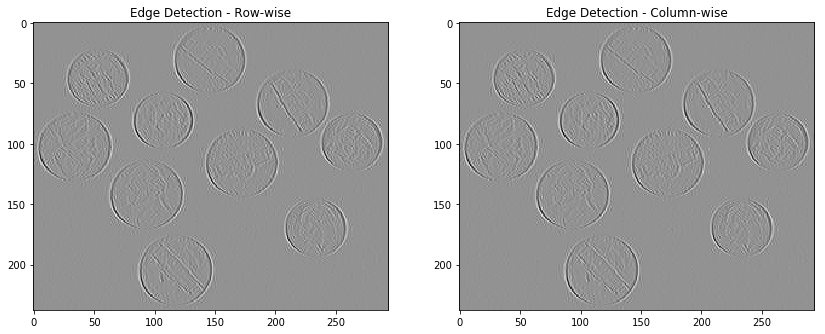

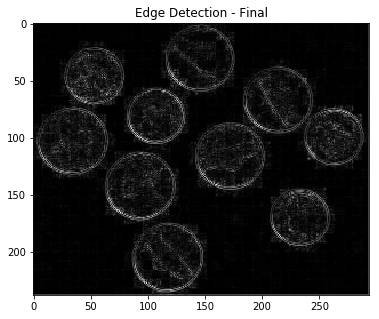

In [7]:
#load coins.jpg
coins = imread('coins.jpg')
plt.figure()
plt.imshow(coins)
plt.title('Original Image')

h = [1, -2, 1]

plt.figure(figsize=(14,6))
#Code for 4.c here:
coin_rows = np.zeros(coins.shape)

for row in range(coins.shape[0]):
    coin_rows[row,:] = signal.convolve(coins[row,:], h, 'same')

plt.subplot(121)
plt.imshow(coin_rows, 'gray')
plt.title('Edge Detection - Row-wise')

#Code for 4.d here:
coin_cols = np.zeros(coins.shape)

for col in range(coins.shape[1]):
    coin_cols[:,col] = signal.convolve(coins[:,col],h,'same')

plt.subplot(122)
plt.imshow(coin_rows, 'gray')
plt.title('Edge Detection - Column-wise')

#Code for 4.e here:
coin_edges = np.zeros(coins.shape)

for r in range(coins.shape[0]):
    for c in range(coins.shape[1]):
        coin_edges[r,c] = (coin_rows[r,c]**2 + coin_cols[r,c]**2)**0.5

plt.figure(figsize=(10,5))
plt.imshow(coin_edges, 'gray')
plt.title('Edge Detection - Final')

## 2D Image Convolution

We don't need to limit ourselves to 1D image convolution. Our filters or "kernels" can be in two dimensions also! We will not spend much time on the math of 2D convolution/filtering in this class because it is best left for ECE 418 (Image and Video Processing); still,  we can use Python to try it out. But let's try something other than filtering this time!

Image convolution is not just for filtering or modifying an image. We can also use convolution to extract information from an image. Remember that convolution is is the process of "flipping and shifting" one signal over another signal. At each shift location, we perform a dot product (or inner product) to see how $\textit{similar}$ the signals are. A larger value at the output means the two signals were more similar. The following image illustrates 2D convolution.

<img src="convolution.jpg">

More formally, say we have a $3x3$ convolution kernel $\mathcal{K}$ where the center pixel is at index $(0,0)$, the result of the 2D convolution at pixel $(i,j)$ for image $I$ is given by:

$$
O(i,j) = \sum_{k=-1}^{1}\sum_{l=-1}^{1}I(i-k,j-l)\cdot\mathcal{K}(k,l)
$$

Now, why is this useful? Suppose you want to design a system to recognize handwritten digits. How can you tell the difference between a "1" and a "4", for example? Think about how you as a human can separate these numbers! They both typically have one large vertical line down the middle, but we know we can differentiate them because a "4" has another shorter vertical line (depending how you draw it) and a horizontal line connecting them. This is where 2D convolution can help us! How about we create convolution kernels to highlight features we know to be discriminative, like horizontal and vertical lines.

The below code cell includes a function to perform 2D image convolution on a target image given a convolution kernel. We have also provided two 2D kernels: one for horizontal features and another for vertical features.

In [8]:
def convolve_2d(image,kernel):
    result = signal.convolve2d(image,kernel,'same')
    result[result < 0] = 0 #Keep values non-negative
    return result

#identify horizontal lines
horiz_kernel = np.array([[-2,-2,-2,-2,-2],
                         [1,1,1,1,1],
                         [1,1,1,1,1],
                         [1,1,1,1,1],
                         [-2,-2,-2,-2,-2]])

#identify vertical lines
vert_kernel = np.array([[-2,1,1,1,-2],
                        [-2,1,1,1,-2],
                        [-2,1,1,1,-2],
                        [-2,1,1,1,-2],
                        [-2,1,1,1,-2]])

In the folder for this lab, we have provided example images of the numbers "1", "4", and "8" from the popular MNIST dataset. These images are 28x28 and grayscale. Let's see what our filters can identify in the ``one.jpg`` image! Note the different scales on the feature image colorbars.

In [9]:
one = imread('one.jpg')

plt.figure(figsize = (16,10))
plt.subplot(131)
plt.title('Original')
plt.imshow(one,'gray')

one_horiz = convolve_2d(one,horiz_kernel)
plt.subplot(132)
plt.title('Horizontal Features')
plt.imshow(one_horiz,'hot')
plt.colorbar(fraction=0.05)

one_vert = convolve_2d(one,vert_kernel)
plt.subplot(133)
plt.title('Vertical Features')
plt.imshow(one_vert,'hot')
plt.colorbar(fraction=0.05)

## Exercise 5: 2D Image Convolution for Feature Detection

a. Create similar plots as the above example for the "1" image for the "4" and "8" images in the following code cell.

b. Comment on the results and compare what is highlighted for each number.

c. What is the significance of having negative kernel values around the positive "feature highlighting" values? Try playing around with the kernels or creating your own kernel if you are unsure.


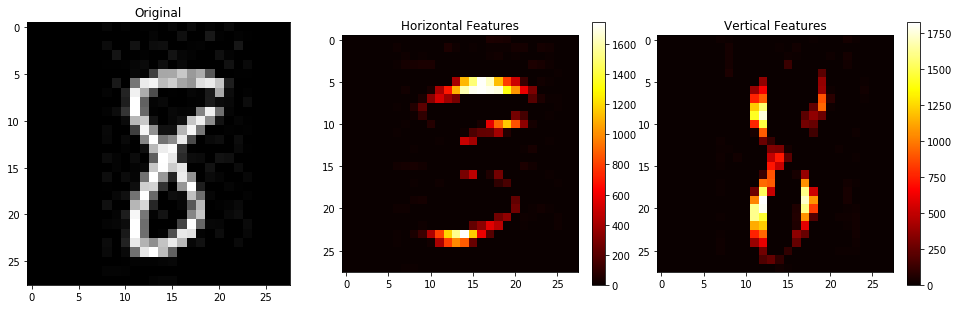

In [10]:
# Code for 5.a here
four = imread('four.jpg')

plt.figure(figsize = (16,10))
plt.subplot(131)
plt.title('Original')
plt.imshow(four,'gray')

four_horiz = convolve_2d(four,horiz_kernel)
plt.subplot(132)
plt.title('Horizontal Features')
plt.imshow(four_horiz,'hot')
plt.colorbar(fraction=0.05)

four_vert = convolve_2d(four,vert_kernel)
plt.subplot(133)
plt.title('Vertical Features')
plt.imshow(four_vert,'hot')
plt.colorbar(fraction=0.05)


eight = imread('eight.jpg')

plt.figure(figsize = (16,10))
plt.subplot(131)
plt.title('Original')
plt.imshow(eight,'gray')

eight_horiz = convolve_2d(eight,horiz_kernel)
plt.subplot(132)
plt.title('Horizontal Features')
plt.imshow(eight_horiz,'hot')
plt.colorbar(fraction=0.05)

eight_vert = convolve_2d(eight,vert_kernel)
plt.subplot(133)
plt.title('Vertical Features')
plt.imshow(eight_vert,'hot')
plt.colorbar(fraction=0.05)

**Answer for 5b:**

The 4 was highlighted very clearly, as it is exclusively horizontal and vertical lines.  It is easy to tell exactly which part of the character is represented in the heatmaps.  The 8, being more curved, is a bit more difficult to distinguish.  The horizontal features pulls out a map that looks like a 3, while the vertical features resembles an 8.  Even though the 8 is curved, the filters were able to identify the regions that are mostly straight.

**Answer for 5c:**

The negative values create sharp boundaries and limit the scope of the feature.  They essentially create a hard cutoff for the detection range instead of allowing the resulting value to trail off as the kernal moves away.  Setting the values to 0 effectively increased the sensitivity, meaning it took less of a horizontal/vertical feature to trigger the output, so thinner lines are detected.  Making the values more negative makes the filter less sensitive to thin lines.

For the final activity, we will explore an example of a non-linear system. First, a bit of background.

There are many different types of noise that can appear in images. One such type is salt-and-pepper noise. This noise occurs when pixels in a camera or an existing image become fully active or inactive. In other words, a normal pixel either takes on its minimum or maximum possible value. The following code cell shows an original image and a version of it that has been corrupted by 20% salt-and-pepper noise (20% of the pixels are affected). In this activity, we will see whether we can use our LSI systems from before to denoise our image.

Text(0.5,1,'Image with 20% Salt-and-Pepper Noise')

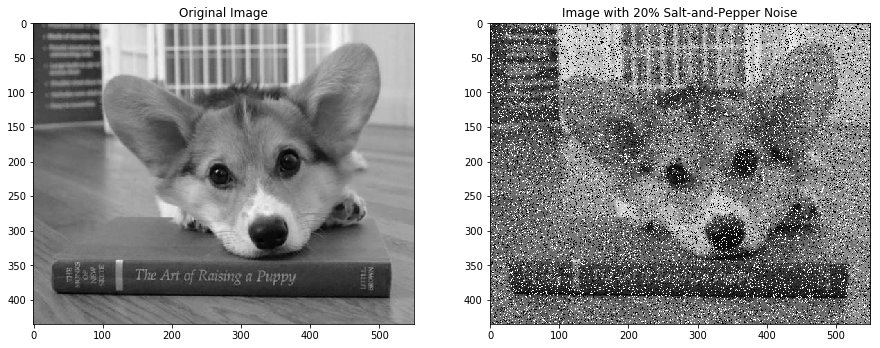

In [11]:
clean_image = imread('clean-image.jpg')
noisy_image = imread('noisy-image.jpg')
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(clean_image,'gray')
plt.title('Original Image')
plt.subplot(122)
plt.imshow(noisy_image,'gray')
plt.title('Image with 20% Salt-and-Pepper Noise')

## Exercise 6: Non-Linear Systems are Cool Too!

We will attempt to use two different filters: a 5x5 mean filter and a 5x5 median filter. Note that a median filter is a non-linear system! A 5x5 median filter simply takes the median of the 25 pixels surrounding the center pixel in the filter and assigns that value to the center pixel.

a. Explain/prove why the median filter is a non-linear system. You may write your answer with respect to a one-dimensional median filter. 

b. Apply a 5x5 mean filter to the noisy image and plot the result. You can do this two different ways. You can apply a length-5 mean filter along the rows and columns in any order or use our $\textrm{convolve_2d()}$ function from before with an appropriate filter you create.

c. Apply a 5x5 median filter to the noisy image and plot the result. Use $\textrm{signal.medfilt()}$ to perform the filtering. Look up the scipy documentation for notes on this function's usage.

d. Comment on the differences. Which filter seems to work better? Why do you think so?

Text(0.5,1,'5x5 Median Filter')

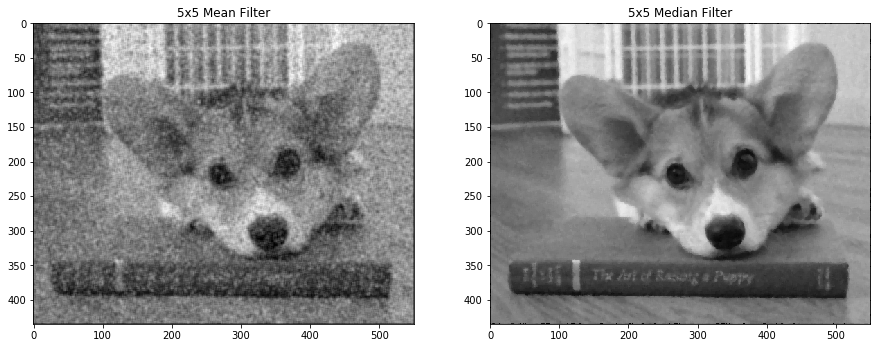

In [12]:
plt.figure(figsize=(15,15))

# Code for 6.b
mean_kernal = np.ones((5,5))
mean_kernal /= 25
mean = convolve_2d(noisy_image, mean_kernal)
plt.subplot(121)
plt.imshow(mean, 'gray')
plt.title('5x5 Mean Filter')

# Code for 6.c
median = signal.medfilt(noisy_image, 5)
plt.subplot(122)
plt.imshow(median, 'gray')
plt.title('5x5 Median Filter')


**Answer for 6.a here:**

The median filter is non-linear because a linear combination of inputs may not be the same as a linear combination of outputs.  Since calculating the median involves sorting the relevant inputs, combining inputs in different ratios may change the way the values are sorted and therefore change the median.

Consider the following:

$$a=\{1,2,3,0,0\} -> \{1\}$$
$$b=\{0,3,4,0,5\} -> \{3\}$$
$$2a=\{2,4,6,0,0\} -> \{2\}$$
$$3b=\{0,9,12,0,15\} -> \{9\}$$
$$2a+3b=\{2,13,18,0,15\} -> \{13\} \neq \{2\}+\{9\}=\{11\}$$


**Answer for 6.d here:**

The median filter is the obvious winner.  This filter performs better than the mean filter because the mean is affected by values of 0 and 1, while the median filter is able to completely ignore those values since it looks at the center of a sorted list.

## Submission Instructions

Make sure to place all image and data files along with your .ipynb lab report (this file) in one folder, zip the folder, and submit it to Compass under the Lab 2 assignment. Please name the zip file ``<netid>_Lab2``.